# Running regression on the dataframe we developed from our SQL db

Reference material for the meaning of each column can be found here: https://labrosa.ee.columbia.edu/millionsong/pages/field-list   
Mode: 1 = minor, 0 = major

In [23]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>")) #reduce margins in jupyter notebook

In [24]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
#import patsy
import matplotlib.pyplot as plt
#from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import RidgeCV

In [25]:
!ls # what did I call those csv files?

MSongsDB                        images
README.md                       million_songs.csv
amazon_ec2_notes.ipynb          regression_on_df.ipynb
create_track_metadata_db_new.py scrape_top_100.ipynb
data_cleaning.ipynb             subset_extraction.ipynb
final_ranked_song_db.csv        top_single_prediction.key
full_extraction.ipynb           track_metadata.db
historical_top_100.csv


In [26]:
million_songs = pd.DataFrame.from_csv('/Users/sumac/projects/metis/coursework/project_2/final_ranked_song_db.csv',sep=',') #import csv

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [27]:
million_songs.head() # take a look at this pretty data!

,artist_name,rating,title,year,release,duration,artist_familiarity,artist_hotttnesss,key,loudness,mode,song_hotttnesss,tempo,time_signature
0,Mark Dinning,5,Teen Angel,1960,True Rock N Roll 3CD Set,158.95465,0.469933,0.334437,0,-12.697,1,-1.000000,100.699,4
1,Jimmy Jones,8,Handy Man,1960,The Greatest Rock 'n' Roll Hits,123.89832,0.550149,0.346467,10,-12.036,1,-1.000000,143.655,4
2,Chubby Checker,10,The Twist,1960,Hits of The 60's Volume 1,164.36200,0.631271,0.439454,11,-9.814,0,-1.000000,154.208,7
3,Chubby Checker,9,The Twist,1962,Hits of The 60's Volume 1,164.36200,0.631271,0.439454,11,-9.814,0,-1.000000,154.208,7
4,Bobby Rydell,12,Wild One,1960,The Ultimate Sixties Collection,136.88118,0.504600,0.368641,7,-8.317,1,0.731105,151.581,3


In [19]:
million_songs.columns

Index(['artist_name', 'rating', 'title', 'year', 'release', 'duration',
       'artist_familiarity', 'artist_hotttnesss', 'key', 'loudness', 'mode',
       'song_hotttnesss', 'tempo', 'time_signature'],
      dtype='object')

In [18]:
million_songs.head()

,artist_name,rating,title,year,release,duration,artist_familiarity,artist_hotttnesss,key,loudness,mode,song_hotttnesss,tempo,time_signature
0,Mark Dinning,5,Teen Angel,1960,True Rock N Roll 3CD Set,158.95465,0.469933,0.334437,0,-12.697,1,-1.000000,100.699,4
1,Jimmy Jones,8,Handy Man,1960,The Greatest Rock 'n' Roll Hits,123.89832,0.550149,0.346467,10,-12.036,1,-1.000000,143.655,4
2,Chubby Checker,10,The Twist,1960,Hits of The 60's Volume 1,164.36200,0.631271,0.439454,11,-9.814,0,-1.000000,154.208,7
3,Chubby Checker,9,The Twist,1962,Hits of The 60's Volume 1,164.36200,0.631271,0.439454,11,-9.814,0,-1.000000,154.208,7
4,Bobby Rydell,12,Wild One,1960,The Ultimate Sixties Collection,136.88118,0.504600,0.368641,7,-8.317,1,0.731105,151.581,3


In [41]:
data.head()

,rating,year,duration,artist_familiarity,artist_hotttnesss,key,loudness,mode,song_hotttnesss,tempo,time_signature
0,5,1960,158.95465,0.469933,0.334437,0,-12.697,1,-1.000000,100.699,4
1,8,1960,123.89832,0.550149,0.346467,10,-12.036,1,-1.000000,143.655,4
2,10,1960,164.36200,0.631271,0.439454,11,-9.814,0,-1.000000,154.208,7
3,9,1962,164.36200,0.631271,0.439454,11,-9.814,0,-1.000000,154.208,7
4,12,1960,136.88118,0.504600,0.368641,7,-8.317,1,0.731105,151.581,3


In [49]:
drop_list = ['artist_name', 'title','release'] #get rid of cols we don't need for regression
data = million_songs.drop(drop_list,axis=1)

In [50]:
keys = pd.get_dummies(data['key'], prefix='key', drop_first=True) # create our dummy columns and put them in their own db to append later
modes = pd.get_dummies(data['mode'], prefix='mode', drop_first=True)
time_signatures = pd.get_dummies(data['time_signature'], prefix='time_signature', drop_first=True)
ratings = pd.get_dummies(data['rating'], prefix='rating', drop_first=True)

reg_data = data.drop(['key','time_signature','mode','rating'], axis=1)

In [52]:
reg_data.head()

,rating,year,duration,artist_familiarity,artist_hotttnesss,key,loudness,mode,song_hotttnesss,tempo,...,rating_91,rating_92,rating_93,rating_94,rating_95,rating_96,rating_97,rating_98,rating_99,rating_100
0,5,1960,158.95465,0.469933,0.334437,0,-12.697,1,-1.000000,100.699,...,0,0,0,0,0,0,0,0,0,0
1,8,1960,123.89832,0.550149,0.346467,10,-12.036,1,-1.000000,143.655,...,0,0,0,0,0,0,0,0,0,0
2,10,1960,164.36200,0.631271,0.439454,11,-9.814,0,-1.000000,154.208,...,0,0,0,0,0,0,0,0,0,0
3,9,1962,164.36200,0.631271,0.439454,11,-9.814,0,-1.000000,154.208,...,0,0,0,0,0,0,0,0,0,0
4,12,1960,136.88118,0.504600,0.368641,7,-8.317,1,0.731105,151.581,...,0,0,0,0,0,0,0,0,0,0


In [51]:
reg_data = pd.concat([data,keys,modes,time_signatures, ratings], axis = 1) #append dbs with keys, modes, time_signatures, ratings
reg_data.head()

,rating,year,duration,artist_familiarity,artist_hotttnesss,key,loudness,mode,song_hotttnesss,tempo,...,rating_91,rating_92,rating_93,rating_94,rating_95,rating_96,rating_97,rating_98,rating_99,rating_100
0,5,1960,158.95465,0.469933,0.334437,0,-12.697,1,-1.000000,100.699,...,0,0,0,0,0,0,0,0,0,0
1,8,1960,123.89832,0.550149,0.346467,10,-12.036,1,-1.000000,143.655,...,0,0,0,0,0,0,0,0,0,0
2,10,1960,164.36200,0.631271,0.439454,11,-9.814,0,-1.000000,154.208,...,0,0,0,0,0,0,0,0,0,0
3,9,1962,164.36200,0.631271,0.439454,11,-9.814,0,-1.000000,154.208,...,0,0,0,0,0,0,0,0,0,0
4,12,1960,136.88118,0.504600,0.368641,7,-8.317,1,0.731105,151.581,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# modeling

In [ ]:
# Plot all of the variable-to-variable relations as scatterplots
sns.pairplot(reg_data, height=1.2, aspect=1.5);

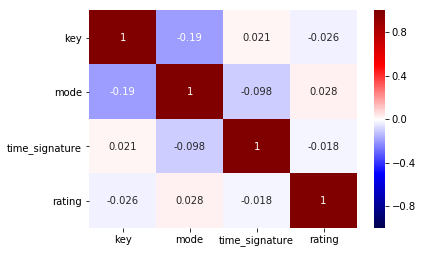

In [31]:
sns.heatmap(reg_data.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);